In [1]:
import sys
sys.path.append('/Users/mac/Downloads/RL-book-master')


In [62]:
from rl.markov_process import MarkovProcess, FiniteMarkovProcess
from rl.markov_process import Transition, FiniteMarkovRewardProcess, RewardTransition
from rl.distribution import Categorical, Constant, Choose
from typing import Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt

In [63]:
class Snakeandladder(FiniteMarkovProcess[int]):
    
    def __init__(self, jump:Dict[int, int], N:int):
        self.N = N
        self.jump = jump
        super().__init__(self.get_transition_map())
      
        
    
    def get_transition_map(self) -> \
    Transition[int]:
        d: Dict[int, Categorical[int]] = {}
        
        for i in range(1 + self.N):
            if i in self.jump.keys():
                continue
            elif i == self.N:
                d[i] = None
            else:
                nextstate = {}
                for j in range(1, 7, 1):
                    if (i + j) in self.jump.keys():
                        nextstate[self.jump[i + j]] = 1.0 / 6
                    elif i + j > self.N:
                        if (2 * self.N - i - j) in self.jump.keys():
                            if self.jump[2 * self.N - i - j] in nextstate.keys(): 
                                nextstate[self.jump[2 * self.N - i - j]] += 1.0 / 6
                            else:
                                nextstate[self.jump[2 * self.N - i - j]] = 1.0 / 6 
                        elif (2 * self.N - i - j) in nextstate.keys():
                            nextstate[2 * self.N - i - j] += 1.0 / 6 
                        else:
                            nextstate[2 * self.N - i - j] = 1.0 / 6 
                    else:
                        nextstate[i + j] = 1.0 / 6
                d[i] = Categorical(nextstate)
        return d
                
                
            
            
                

In [69]:
my_jump = {1:38,4:14,9:31,16:6,21:42,36:44,47:26,49:11,51:67,56:53,
                                62:19,64:60,71:91,80:100,87:24,93:73,95:75,98:78}
sal1 = Snakeandladder(my_jump, 100)
my_traces = sal1.traces(Choose([0]))



average number is  54.7599


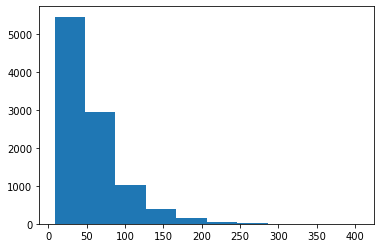

In [83]:
snake_trace_list = [list( next(my_traces) ) for i in range(10000) ]
plt.hist([len(x) for x in snake_trace_list])
print("average number is ", np.mean([len(x) for x in snake_trace_list]))

In [79]:
class FrogMRP(FiniteMarkovRewardProcess[int]):
    
    def __init__(self, N:int):
        self.N = N
        super().__init__(self.get_transition_reward_map())
      
        
    
    def get_transition_reward_map(self) -> \
    RewardTransition[int]:
        d: Dict[int, Categorical[Tuple[int, int]]] = {}
        for i in range(1 + self.N):
            if i == self.N:
                d[i] = None
            else:
                d1 = {}
                for j in range(i + 1, self.N + 1):
                    d1[(j, 1)] = 1.0 / (self.N - i)
                d[i] = Categorical(d1)
        return d
                
     

In [84]:
frog1 = FrogMRP(20)
frog1.get_value_function_vec(gamma = 1)[0]    

3.5977396571436806

In [35]:
class SnakeandladderMRP(FiniteMarkovRewardProcess[int]):
    
    def __init__(self, jump:Dict[int, int], N:int):
        self.N = N
        self.jump = jump
        super().__init__(self.get_transition_reward_map())
      
        
    
    def get_transition_reward_map(self) -> \
    RewardTransition[int]:
        d: Dict[int, Categorical[Tuple[int, int]]] = {}
        
        for i in range(1 + self.N):
            if i in self.jump.keys():
                continue
            elif i == self.N:
                d[i] = None
            else:
                nextstate = {}
                for j in range(1, 7, 1):
                    if (i + j) in self.jump.keys():
                        nextstate[(self.jump[i + j], 1)] = 1.0 / 6
                    elif i + j > self.N:
                        if (2 * self.N - i - j) in self.jump.keys():
                            if (self.jump[2 * self.N - i - j], 1) in nextstate.keys():
                                nextstate[(self.jump[2 * self.N - i - j], 1)] += 1.0 / 6
                            else:
                                nextstate[(self.jump[2 * self.N - i - j], 1)] = 1.0 / 6 
                        elif (2 * self.N - i - j, 1) in nextstate.keys():
                            nextstate[(2 * self.N - i - j, 1)] += 1.0 / 6 
                        else:
                            nextstate[(2 * self.N - i - j, 1)] = 1.0 / 6 
                    else:
                        nextstate[(i + j, 1)] = 1.0 / 6
                d[i] = Categorical(nextstate)
        return d
                
                

In [36]:
my_jump = {1:38,4:14,9:31,16:6,21:42,36:44,47:26,49:11,51:67,56:53, 62:19,64:60,71:91,80:100,87:24,93:73,95:75,98:78}
salmrp1 = SnakeandladderMRP(my_jump, 100)

In [85]:
print("expected number is ", salmrp1.get_value_function_vec(gamma = 1)[0])

expected number is  54.16854120736832


In [124]:
from rl.chapter2.stock_price_mp import StockPriceMP2, StateMP2
from rl.markov_process import MarkovRewardProcess
from rl.distribution import SampledDistribution, Constant
import numpy as np

In [190]:
class Sp2mrp(MarkovRewardProcess[StateMP2]):
    
    def __init__(self, alpha2 : float, f):
                
        self.stock = StockPriceMP2(alpha2)
        self.f  = f
        
    def transition_reward(self, s: StateMP2) -> SampledDistribution[Tuple[StateMP2,float]]:
        
        def sr(s = s) -> Tuple[StateMP2,float]:
            s1 : StateMP2 = self.stock.transition(s).sample()
            reward: float = self.f(s1)
            return s1, reward
        
        return SampledDistribution(sr)
    def get_value_function(self, s: StateMP2, iternum: int, trnum: int, gamma: float):
        lst = []
        for i in range(trnum): 
            value = 0
            s1 = s
            
            for j in range(iternum):
              
                s1, reward = self.transition_reward(s1).sample()
                
                value += reward * (gamma ** j)
            lst.append(value)
        return np.mean(lst)

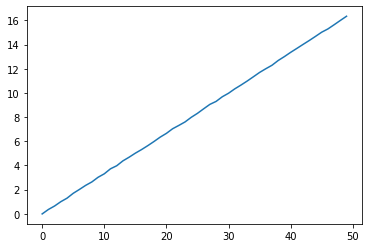

In [199]:
def f(s: StateMP2):
    return s.price * 0.1
smrp = Sp2mrp(alpha2 = 0.75, f = f)
x = []
y = []
for i in range(50):
    
    x.append(i)
    y.append(smrp.get_value_function(s = StateMP2(price = i, is_prev_move_up = None), iternum = 100, trnum = 100, gamma = 0.7))
plt.plot(x, y)